# Tools for extracting NIRSpec spectra from 2D cutouts

*February 23, 2023*

1. Run the preprocessing pipline through extracting 2D cutouts
1. Drizzle the cutouts to a combined spectrum
1. Extract 1D spectrum
1. Fit redshift

In [1]:
# Environment variables for jwst pipeline
import os

for k in ['CRDS_SERVER_URL','CRDS_PATH']:
    if k not in os.environ:
        print(f"Environment variable {k} not set, `jwst` pipeline won't work")
    else:
        print(f"{k}: {os.environ[k]}")
        

CRDS_SERVER_URL: https://jwst-crds.stsci.edu
CRDS_PATH: /Users/gbrammer/Research/grizli/crds_cache


In [2]:
# Are we on a GitHub codespace?
import os

if os.getcwd().startswith('/workspaces/msaexp'):
    import os
    os.environ['CRDS_PATH'] = os.path.join('/tmp/', 'crds_cache')

    if not os.path.exists(os.environ['CRDS_PATH']):
        ! mkdir {os.environ['CRDS_PATH']}

    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

    print('On codespace: ', os.environ['CRDS_PATH'], os.environ['CRDS_SERVER_URL'])

    workdir  = '/workspaces/msaexp/docs/examples/codespace'
    if not os.path.exists(workdir):
        ! mkdir {workdir}
    
    os.chdir(workdir)
else:
    print('(not on a codespace)')

(not on a codespace)


In [20]:
import os
import glob
import yaml
import warnings

import numpy as np
import matplotlib.pyplot as plt

import grizli
from grizli import utils, jwst_utils
jwst_utils.set_quiet_logging()
utils.set_warnings()

import astropy.io.fits as pyfits
from jwst.datamodels import SlitModel
import jwst

import msaexp
from msaexp import pipeline

print(f'grizli version = {grizli.__version__}')
print(f'msaexp version = {msaexp.__version__}')
print(f'jwst version = {jwst.__version__}')

grizli version = 1.8.3
msaexp version = 0.6.8.dev2+ge8dbb94.d20230331
jwst version = 1.9.6


# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [4]:
# MACS0647-JD, GO-1433 Coe et al.
#os.chdir('/Users/gbrammer/Research/JWST/Projects/NIRSpec/j0647/')
prog = 1433

outroot = 'macsj0647'
file_version = 'v1'

os.getcwd()

'/usr/local/share/python/msaexp/docs/examples'

In [8]:
# Query NIRSpec data for a program name

# Just most recent visit with 3-slitlets
import mastquery.jwst
extra = mastquery.jwst.make_query_filter('expstart', range=[59990, 80000])

masks = pipeline.query_program(prog, download=True, extra_filters=extra, detectors=['nrs1'])

# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [9]:
files = glob.glob(f'jw0{prog}*rate.fits')

groups = pipeline.exposure_groups(files=files)

print('\nFiles:\n======')
print(yaml.dump(dict(groups)))

   N  value     
====  ==========
   3  jw01433023001-01-clear-prism-nrs1

Files:
jw01433023001-01-clear-prism-nrs1:
- jw01433023001_04101_00002_nrs1_rate.fits
- jw01433023001_04101_00003_nrs1_rate.fits
- jw01433023001_04101_00001_nrs1_rate.fits



In [12]:
pipe = pipeline.NirspecPipeline(mode='jw01433023001-01-clear-prism-nrs1',
                                source_ids=[3349]) 

# (2023-03-31 07:18:14.919)
msaexp.NirspecPipeline: Initialize jw01433023001-01-clear-prism-nrs1
msaexp.NirspecPipeline: jw01433023001_04101_00001_nrs1_rate.fits
msaexp.NirspecPipeline: jw01433023001_04101_00002_nrs1_rate.fits
msaexp.NirspecPipeline: jw01433023001_04101_00003_nrs1_rate.fits
# (2023-03-31 07:18:15.008)
msaexp.utils.pad_msa_metafile: Trim source_id in jw01433023001_01_msa.fits to [3349]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw01433023001-01-clear-prism-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw01433023001_01_msa.fits


## Preprocessing pipeline

1. Apply 1/f correction and identify "snowballs" on the `rate.fits` files
1. Remove "bias" (i.e., simple median) of each exposure
1. Rescale RNOISE array based on empty parts of the exposure
1. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
    - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
    - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
    - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
    - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
    - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
    - Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
1. Parse slit metadata
1. Save slit cutout files of the last pipeline step performed (`phot` = `PhotomStep`)

Subsequent re-initialization of the `NirspecPipeline` object and `full_pipeline` method will skip these steps and just load the saved slit cutouts.

In [13]:
# Run the pipeline to define slits, etc., but don't do extractions yet.  
if not os.path.exists(f'{pipe.mode}.slits.yaml'):
    pipe.full_pipeline(run_extractions=False, initialize_bkg=False)
else:
    print(f'Skip preprocessing: {pipe.mode}')

XXX None
# (2023-03-31 07:18:17.245)

prep.mask_snowballs(**{'visit': {'product': 'jw01433023001-01-clear-prism-nrs1', 'files': ['jw01433023001_04101_00001_nrs1_rate.fits', 'jw01433023001_04101_00002_nrs1_rate.fits', 'jw01433023001_04101_00003_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 24, 'mask_bit': 1024, 'instruments': ['NIRSPEC'], 'max_fraction': 0.3, 'unset4': False, 'kwargs': {}})

Snowball mask: jw01433023001_04101_00001_nrs1_rate.fits  N= 19(f=0.83%)
Snowball mask: jw01433023001_04101_00002_nrs1_rate.fits  N= 23(f=0.96%)
Snowball mask: jw01433023001_04101_00003_nrs1_rate.fits  N= 18(f=0.76%)
msaexp.preprocess : jw01433023001_04101_00001_nrs1_rate.fits  bias offset =   0.004 (from MASKBIAS)
msaexp.preprocess : jw01433023001_04101_00001_nrs1_rate.fits    rms scale =    2.01 (from SCLREADN)
msaexp.preprocess : jw01433023001_04101_00002_nrs1_rate.fits  bias offset =   0.001 (from MASKBIAS)
msaexp.preprocess : jw01433023001_04101_00002_nrs1_rate.fits    rms scale =  

2023-03-31 09:18:21,648 - stpipe.MSAFlagOpenStep - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2587.479237330867.
  warnings.warn(

2023-03-31 09:18:21,931 - stpipe.MSAFlagOpenStep - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2390.307934705575.
  warnings.warn(

2023-03-31 09:18:22,212 - stpipe.MSAFlagOpenStep - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2332.1234049605646.
  warnings.warn(

2023-03-31 09:18:23,684 - stpipe.MSAFlagOpenStep - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astr

# (2023-03-31 07:18:29.678)
msaexp.jwst.MSAFlagOpenStep: jw01433023001_04101_00002_nrs1_rate.fits
# (2023-03-31 07:18:39.001)
msaexp.jwst.MSAFlagOpenStep: jw01433023001_04101_00003_nrs1_rate.fits
# (2023-03-31 07:18:48.252)
msaexp.jwst.Extract2dStep: jw01433023001_04101_00001_nrs1_rate.fits
# (2023-03-31 07:18:48.712)
msaexp.jwst.Extract2dStep: jw01433023001_04101_00002_nrs1_rate.fits
# (2023-03-31 07:18:49.074)
msaexp.jwst.Extract2dStep: jw01433023001_04101_00003_nrs1_rate.fits
# (2023-03-31 07:18:49.447)
msaexp.jwst.FlatFieldStep: jw01433023001_04101_00001_nrs1_rate.fits
# (2023-03-31 07:18:51.001)
msaexp.jwst.FlatFieldStep: jw01433023001_04101_00002_nrs1_rate.fits
# (2023-03-31 07:18:52.418)
msaexp.jwst.FlatFieldStep: jw01433023001_04101_00003_nrs1_rate.fits
# (2023-03-31 07:18:53.841)
msaexp.jwst.PathLossStep: jw01433023001_04101_00001_nrs1_rate.fits
# (2023-03-31 07:18:54.179)
msaexp.jwst.PathLossStep: jw01433023001_04101_00002_nrs1_rate.fits
# (2023-03-31 07:18:54.506)
msaexp.jws

In [14]:
files = glob.glob(f'{pipe.mode}*')
files.sort()
for f in files:
    print(f)

jw01433023001-01-clear-prism-nrs1.log.txt
jw01433023001-01-clear-prism-nrs1.reg
jw01433023001-01-clear-prism-nrs1.slits.yaml


In [15]:
print('Pipeline entries: ', list(pipe.pipe.keys()))
print('Last step: ', pipe.last_step)
print(pipe.mode)

Pipeline entries:  ['wcs', 'open', '2d', 'flat', 'path', 'bar', 'phot']
Last step:  phot
jw01433023001-01-clear-prism-nrs1


## Extracted spectra 

The end products of the preprocessing pipeline are 2D calibrated spectra ([jwst.datamodels.SlitModel](https://jwst-pipeline.readthedocs.io/en/stable/api/jwst.datamodels.SlitModel.html)) for each slitlet.

In [16]:
target = '3349' # JD2
# target = '3593'

slit_files = []
for file in pipe.files:
    slit_files.extend(glob.glob(f"{file.split('nrs')[0]}*phot*{target}*fits"))

slit_files.sort()

slit_files

['jw01433023001_04101_00001_nrs1_phot.101.1433_3349.fits',
 'jw01433023001_04101_00002_nrs1_phot.101.1433_3349.fits',
 'jw01433023001_04101_00003_nrs1_phot.101.1433_3349.fits']

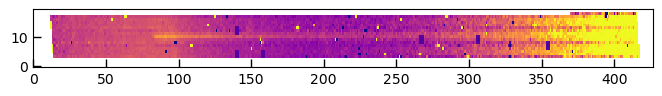

In [17]:
dm = SlitModel(slit_files[0])

sh = dm.data.shape
fig, ax = plt.subplots(1,1,figsize=(8,8*sh[0]/sh[1]*2))
ax.imshow(dm.data, aspect='auto',
          cmap='plasma', vmin=-0.1, vmax=0.5)

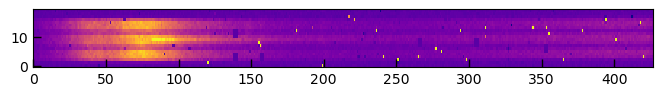

In [18]:
# From original detector image

exp = pyfits.open(f"{dm.meta.filename.split('_phot')[0]}_rate.fits")

slx = slice(dm.xstart, dm.xstart + dm.xsize)
sly = slice(dm.ystart, dm.ystart + dm.ysize)

fig, ax = plt.subplots(1,1,figsize=(8,8*sh[0]/sh[1]*2))
ax.imshow(exp['SCI'].data[sly, slx], aspect='auto',
          cmap='plasma', vmin=-0.1, vmax=0.5)

dm.close()

# Drizzle-combine 2D spectra

This step drizzles the distorted 2D extractions from `extract_2d` to a common output frame and combines them.  

The background subtraction is done by just shifting the stacked 2D spectrum up and down by `bkg_offset` pixels that correspond to the nod offset.

msaexp.drizzle.drizzle_slitlets: 3349 read 3 files
msaexp.drizzle.drizzle_slitlets: id=3349  prism-clear N=3
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  1433_3349
msaexp.drizzle.drizzle_slitlets: output size = (31, 414)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 1433_3349               3349 -0.272 jw01433023001_04101_00001_nrs1_phot.101.1433_3349.fits (20, 427)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 1433_3349               3349 -0.277 jw01433023001_04101_00002_nrs1_phot.101.1433_3349.fits (20, 427)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 1433_3349               3349 -0.267 jw01433023001_04101_00003_nrs1_phot.101.1433_3349.fits (20, 427)


2023-03-31 09:23:12,985 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


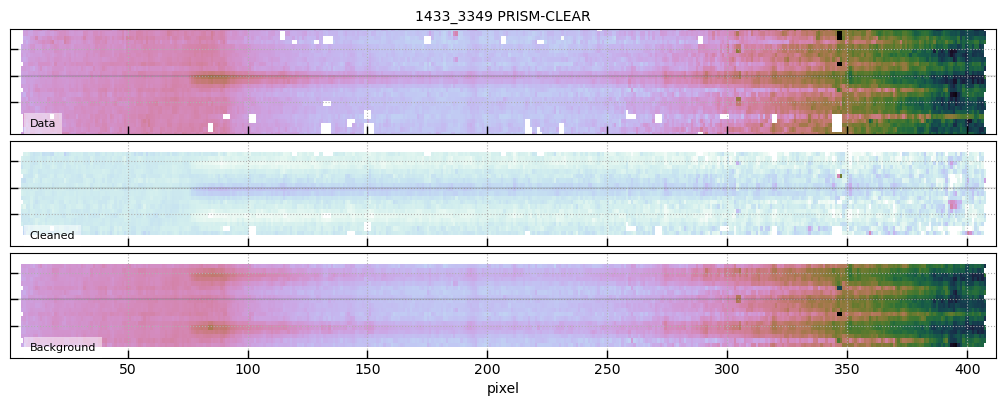

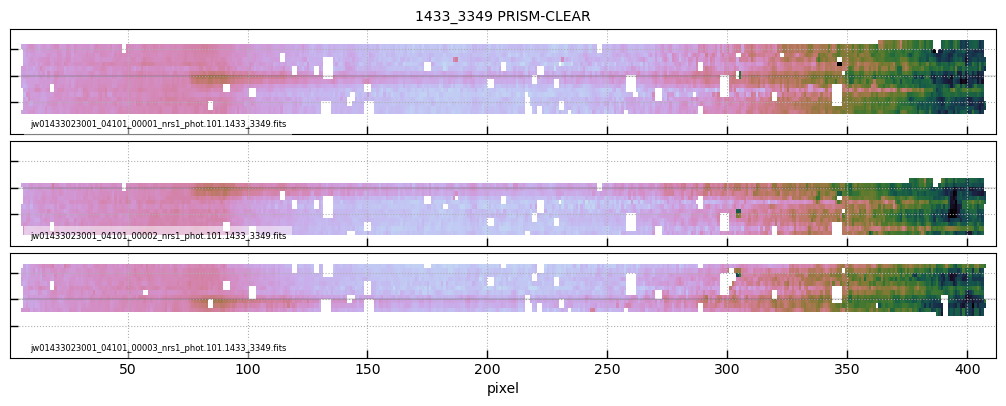

In [19]:
from importlib import reload
import copy

import msaexp.drizzle
reload(msaexp.drizzle); reload(msaexp.utils)
reload(msaexp.drizzle); reload(msaexp.utils) 

DRIZZLE_PARAMS = copy.deepcopy(msaexp.drizzle.DRIZZLE_PARAMS)
DRIZZLE_PARAMS['kernel'] = 'square'
DRIZZLE_PARAMS['pixfrac'] = 1.0

_ = msaexp.drizzle.drizzle_slitlets(target,
                                    output=outroot,
                                    files=slit_files[:],
                                    center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                    fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                    force_nypix=31,         # Y size of output array
                                    bkg_offset=6,           # Number of pixels to roll for background subtraction
                                    bkg_parity=[-1,1],      # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                    log_step=False,         # Log wavelength steps
                                    outlier_threshold=10,   # Outlier rejection threshold
                                    err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                    show_drizzled=True,     # Figures
                                    show_slits=True,
                                    imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                    sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                    bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                   )

figs, hdu_data, wavedata, all_slits, drz_data = _


# Optimal 1D extraction

msaexp.drizzle.extract_from_hdul: Initial center =    1.33, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =   1.08, sigma =   1.17


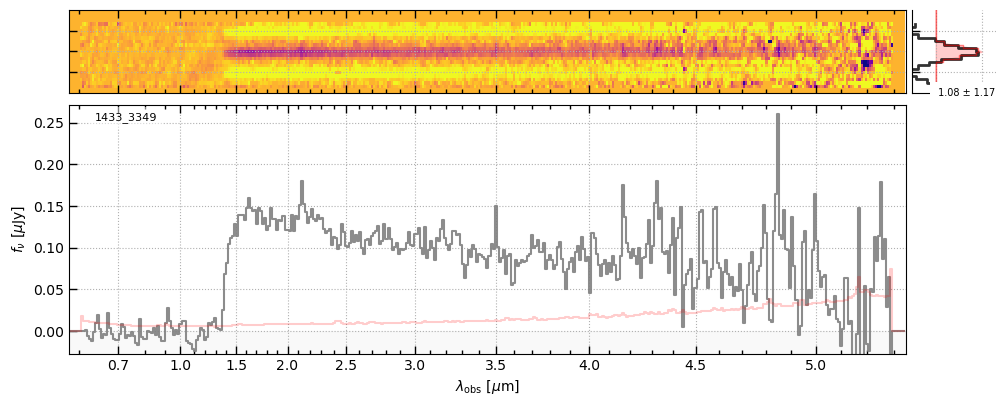

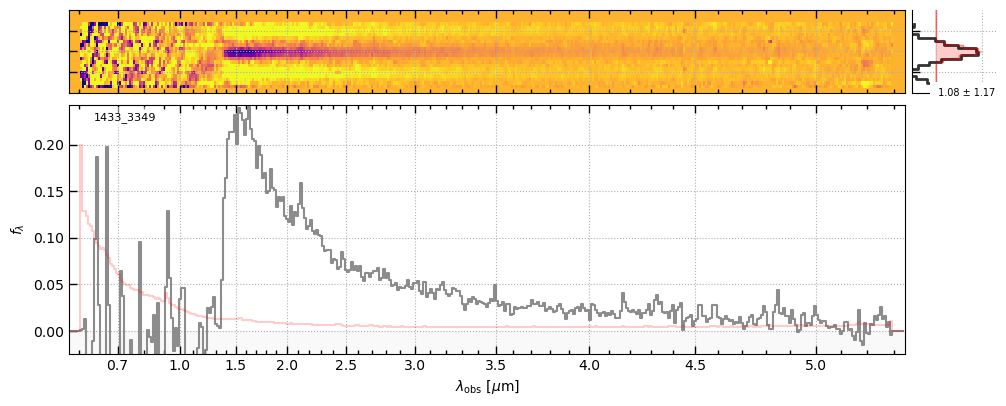

In [21]:
hdul = hdu_data['prism-clear']

outhdu = msaexp.drizzle.extract_from_hdul(hdul,
                                          prf_sigma=0.9, fix_sigma=False,
                                          prf_center=None, fix_center=False,
                                          verbose=True,
                                          )

outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

# Make figures
fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam')
fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')


# Fit redshift

In [22]:
import eazy

try:
    _ = templ # already defined
except:
    if not os.path.exists('templates'):
        eazy.symlink_eazy_inputs()

    otempl = eazy.templates.read_templates_file('templates/sfhz/blue_sfhz_13.param')

    if 1:
        wrest = utils.log_zgrid([300, 5.5e4], 1./500)
        print(wrest.shape)
        templ = []
        for i, t in enumerate(otempl):
            print(i, t.name)
            templ.append(t.smooth_velocity(500., in_place=False))
            templ[-1].resample(wrest, in_place=True)
    else:
        templ = otempl
    

2023-03-31 09:23:57,838 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/eazy/templates.py:356: ResourceWarning: unclosed file <_io.TextIOWrapper name='templates/sfhz/blue_sfhz_13.param' mode='r' encoding='UTF-8'>
  lines = open(templates_file).readlines()



(2604,)
0 corr_sfhz_13_bin0_av0.01.fits
1 corr_sfhz_13_bin0_av0.25.fits
2 corr_sfhz_13_bin0_av0.50.fits
3 corr_sfhz_13_bin0_av1.00.fits
4 corr_sfhz_13_bin1_av0.01.fits
5 corr_sfhz_13_bin1_av0.25.fits
6 corr_sfhz_13_bin1_av0.50.fits
7 corr_sfhz_13_bin1_av1.00.fits
8 corr_sfhz_13_bin2_av0.01.fits
9 corr_sfhz_13_bin2_av0.50.fits
10 corr_sfhz_13_bin2_av1.00.fits
11 corr_sfhz_13_bin3_av0.01.fits
12 corr_sfhz_13_bin3_av0.50.fits
13 fsps_4590.fits


896it [00:01, 466.04it/s]
101it [00:00, 433.37it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# macsj0647_3349.v1.spec.fits
# z = 10.23276
# Fri Mar 31 09:24:01 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# macsj0647_3349.v1.spec.fits
# z = 10.23276
# Fri Mar 31 09:24:01 2023
             line Hg       19.0 ±      6.1
             line Hd       -8.9 ±      6.3
     line NeIII-3968      -15.1 ±      5.8
      line OIII-4363        8.6 ±      6.0
            line OII        7.8 ±      5.8
      line HeII-4687       16.3 ±      7.9
     line NeIII-3867       17.3 ±      6.0
       line HeI-3889       -3.7 ±      6.1
      line OIII-1663      -18.3 ±     29.1
      line CIII-1908      116.4 ±     21.0
      line NIII-1750      -19.9 ±     25.9
            line Lya     -254.4 ±    110.8
           line MgII        2.6 ±      8.2
       line NeV-3346        9.0 ±      6.2
      line NeVI-3426        8.2 ±      6.1


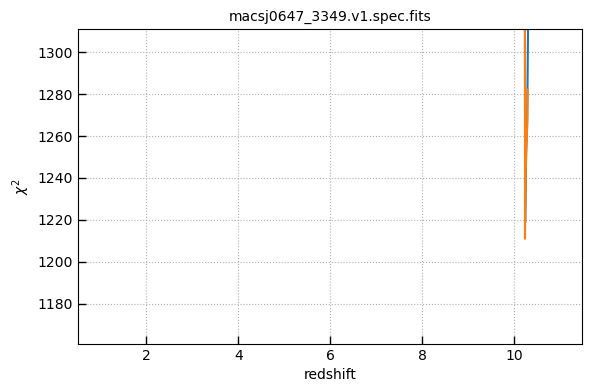

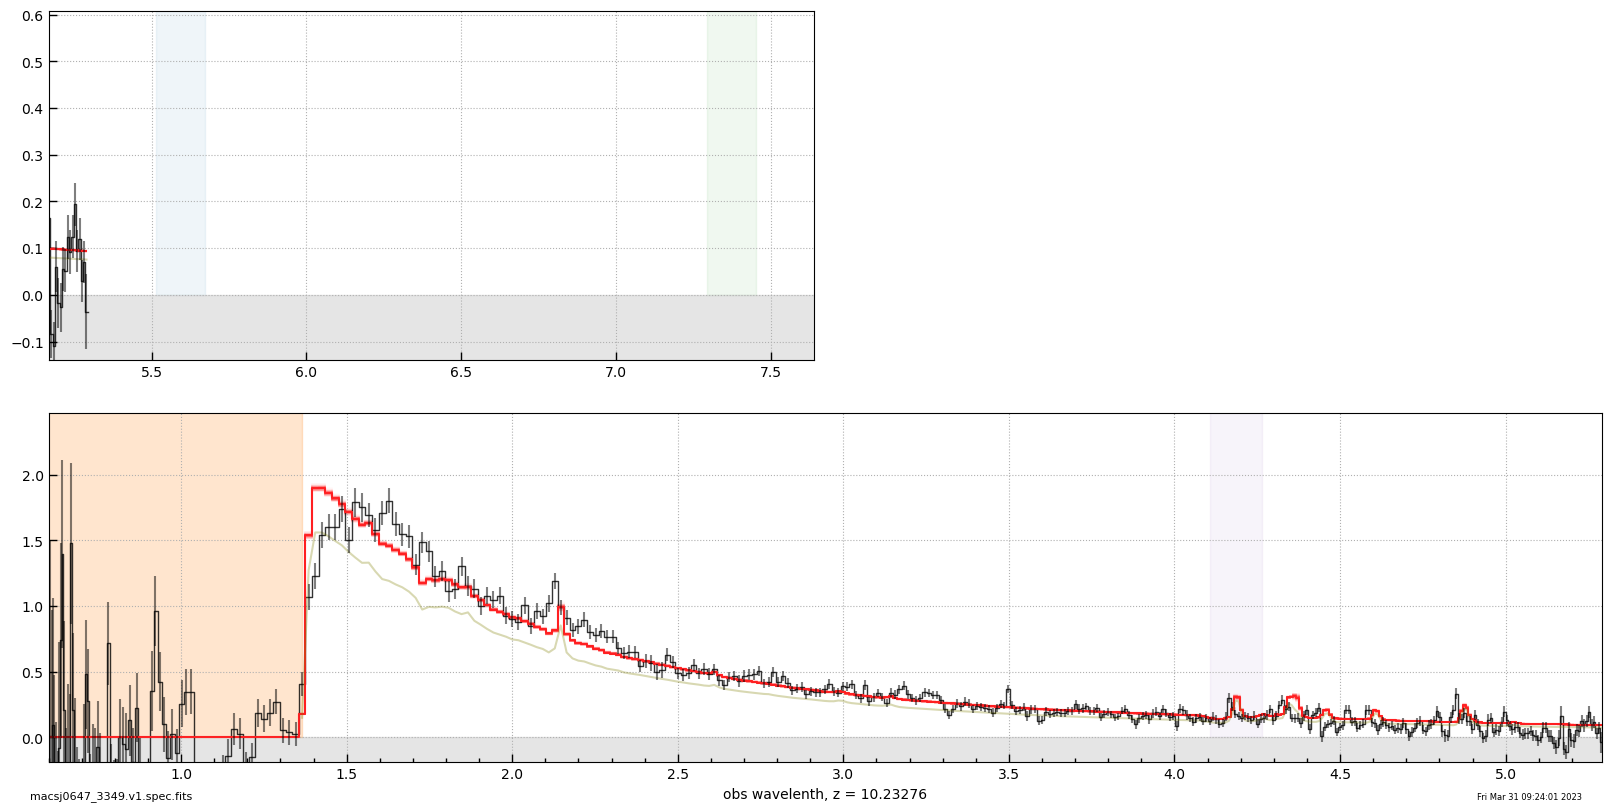

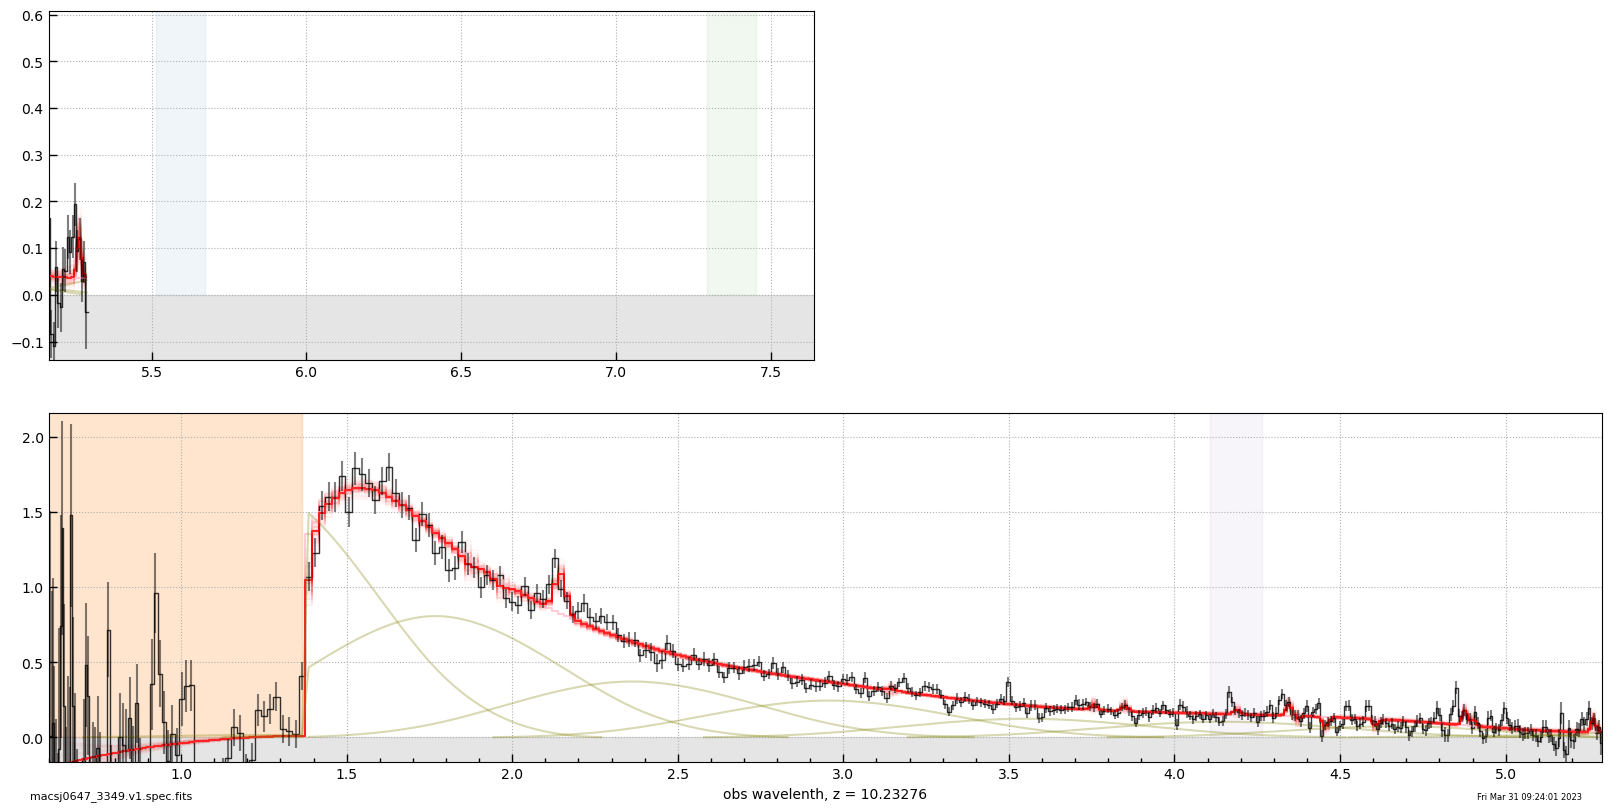

In [23]:
import msaexp.spectrum
import astropy.units as u

msaexp.spectrum.FFTSMOOTH = True

file = f'{outroot}_{target}.{file_version}.spec.fits'

zfit_kwargs = dict(z0=[1.0, 11],
                   eazy_templates=templ,
                   vel_width=50,
                   scale_disp=1.0,
                   nspline=11,
                   Rline=2000,
                   use_full_dispersion=False,
                   is_prism=True,
                   sys_err=0.02,
                   ranges=((4600, 6800), (8800, 1.1e4)),
                  )

plt_kwargs = dict(eazy_templates=None,
                  vel_width=50,
                  scale_disp=1.0,
                  nspline=11,
                  Rline=2000,
                  use_full_dispersion=True,
                  is_prism=True,
                  sys_err=0.02,
                  ranges=((4600, 6800), (8800, 1.1e4)),
                  scale_uncertainty_kwargs={'order':4},
                  plot_unit=u.microJansky,
                  )

zfit = msaexp.spectrum.fit_redshift(file=file, **zfit_kwargs)



Set SCALE_UNCERTAINTY:  [-0.00441272  0.06698655 -0.33097705  0.58783293 -0.21464279]

# line flux err
# flux x 10^-20 erg/s/cm2
# macsj0647_3349.v1.spec.fits
# z = 10.17145
# Fri Mar 31 09:26:07 2023
             line Hg       45.3 ±      7.3
             line Hd       23.5 ±      7.0
     line NeIII-3968       16.6 ±      6.4
      line OIII-4363       19.7 ±      6.9
            line OII       29.4 ±      6.9
      line HeII-4687       19.4 ±      9.1
     line NeIII-3867       34.5 ±      6.2
       line HeI-3889       16.4 ±      6.2
      line OIII-1663       -4.0 ±     37.9
      line CIII-1908      144.0 ±     27.2
      line NIII-1750       -7.1 ±     33.1
            line Lya     -442.8 ±     94.9
           line MgII      -10.1 ±      8.5
       line NeV-3346       12.7 ±      6.2
      line NeVI-3426       -2.2 ±      5.8


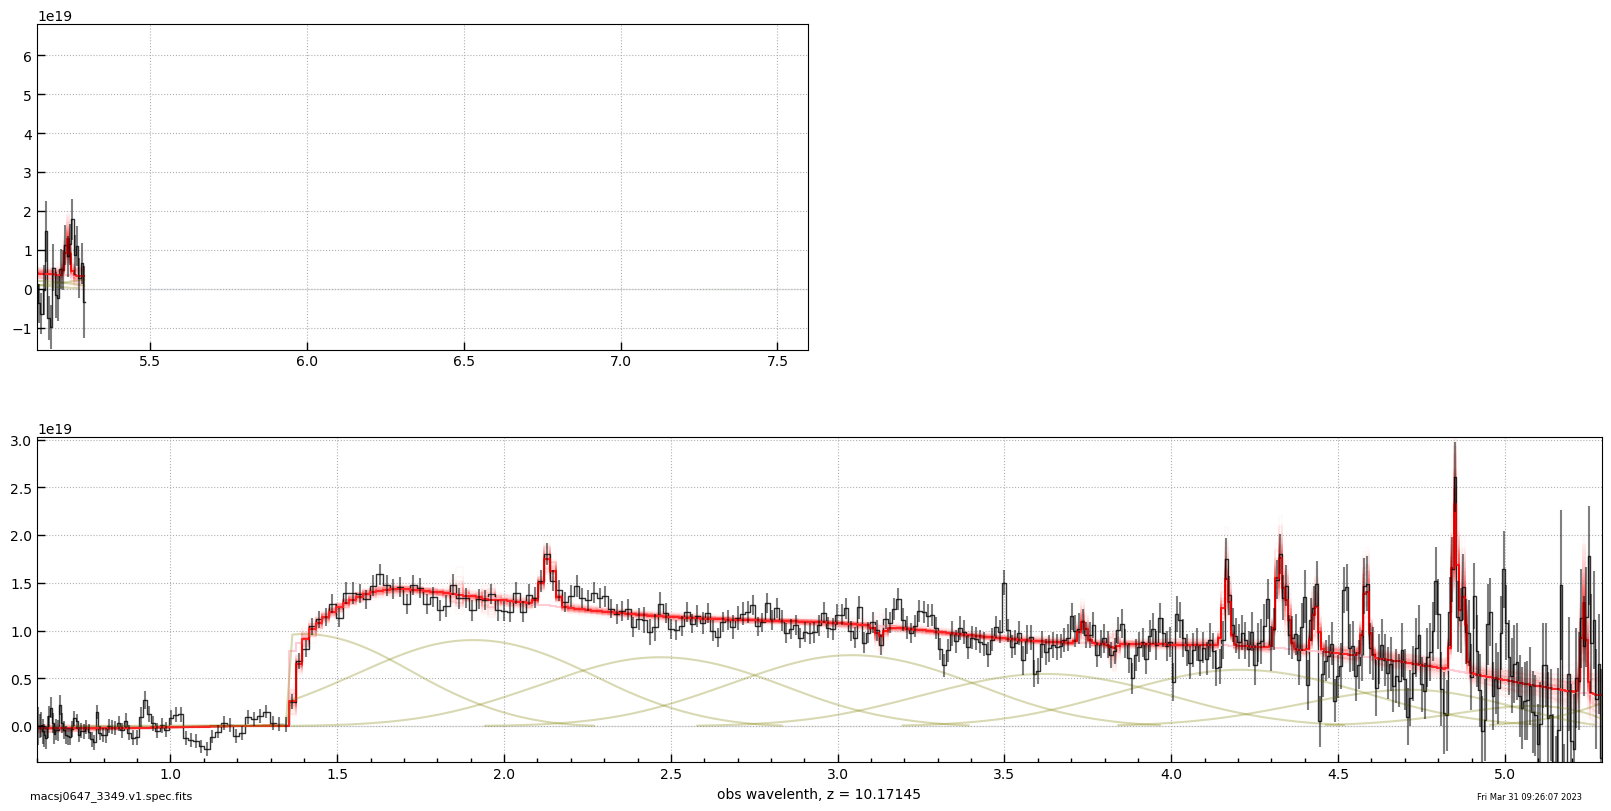

In [25]:
reload(msaexp.spectrum)

best_z = zfit[1].meta['z']

if target in ['3349', '3593', '3314']:
    best_z = 10.17145

msaexp.spectrum.SCALE_UNCERTAINTY = 1.

_ = msaexp.spectrum.plot_spectrum(file=file,
                                  z=best_z,
                                  **plt_kwargs,
                                  )

402it [00:01, 362.07it/s]
101it [00:00, 369.99it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# macsj0647_3349.v1.spec.fits
# z = 10.17033
# Fri Mar 31 09:26:16 2023
             line Hg       45.4 ±      7.3
             line Hd       23.5 ±      7.0
     line NeIII-3968       17.1 ±      6.4
      line OIII-4363       19.9 ±      6.9
            line OII       29.0 ±      6.9
      line HeII-4687       19.0 ±      9.1
     line NeIII-3867       34.2 ±      6.2
       line HeI-3889       17.0 ±      6.3
      line OIII-1663       -3.4 ±     37.1
      line CIII-1908      144.4 ±     26.7
      line NIII-1750       -6.6 ±     32.4
            line Lya     -443.8 ±     94.1
           line MgII      -10.1 ±      8.5
       line NeV-3346       12.8 ±      6.2
      line NeVI-3426       -2.5 ±      5.8


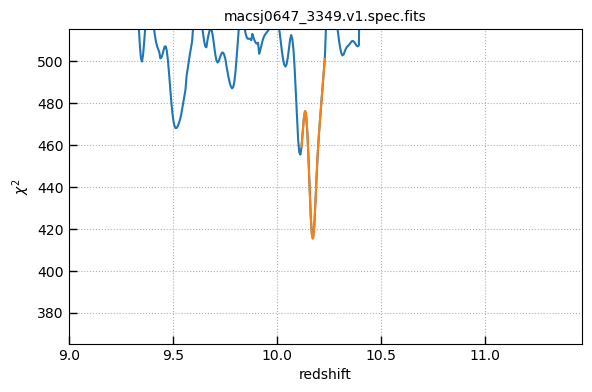

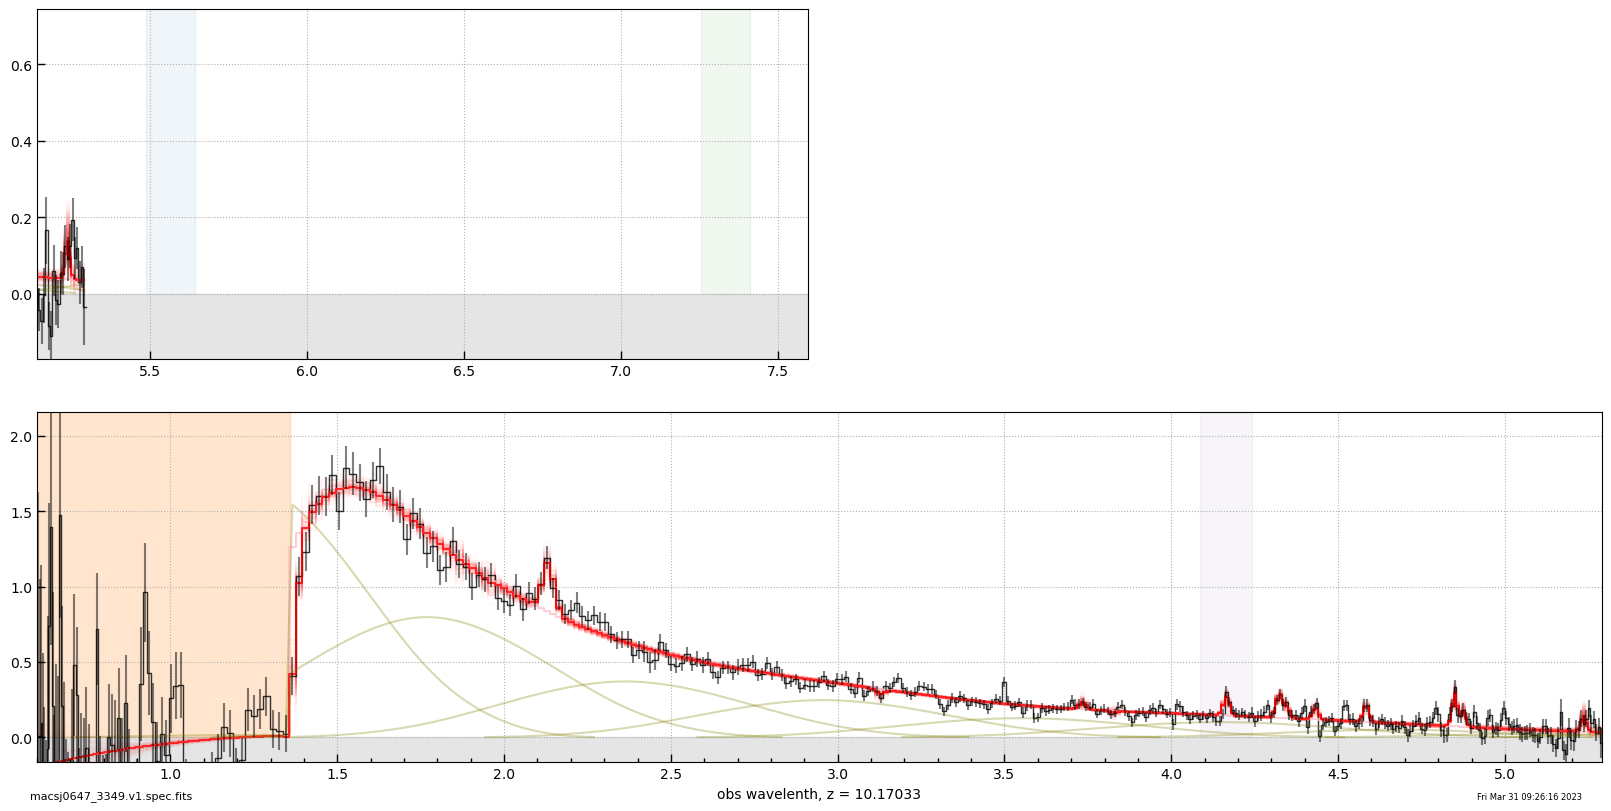

In [26]:
# Refit with just line templates

best_z = zfit[1].meta['z']

zfit_kwargs['z0'] = best_z + np.array([-0.1, 0.1])*(1+best_z)
zfit_kwargs['eazy_templates'] = None

zfit = msaexp.spectrum.fit_redshift(file=file, zstep=(0.0005, 0.0001), **zfit_kwargs)

best_z = zfit[1].meta['z']


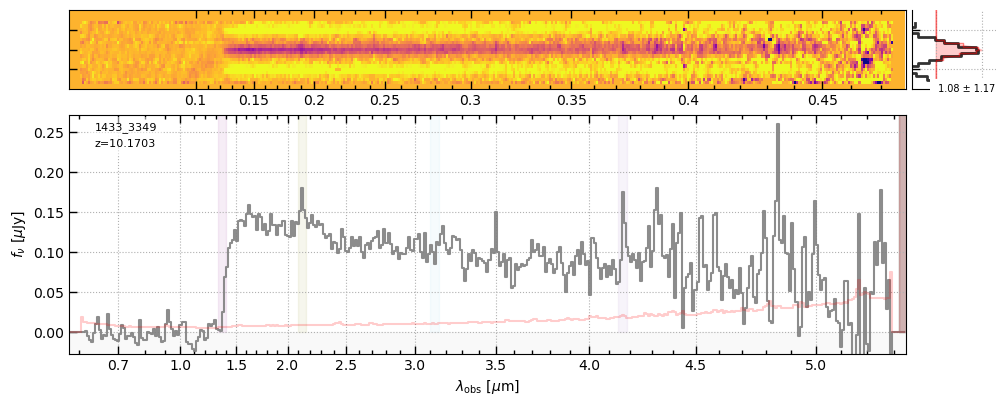

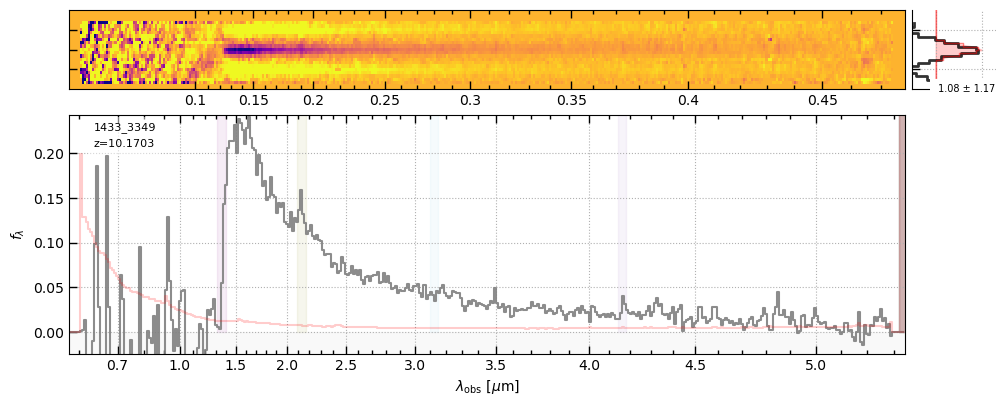

In [27]:
# Remake figures
fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu', z=best_z)
fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam', z=best_z)
fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')


# Do background subtraction at the exposure level

Do A-B subtractions in the pixel space of the original 2D extractions, which may be a bit more robust than in the drizzled spectra.

In [29]:
pipe.set_background_slits()

msaexp.read_data: jw01433023001_04101_00001_nrs1_phot.101.1433_3349.fits 1433_3349
msaexp.read_data: jw01433023001_04101_00002_nrs1_phot.101.1433_3349.fits 1433_3349
msaexp.read_data: jw01433023001_04101_00003_nrs1_phot.101.1433_3349.fits 1433_3349


True

2023-03-31 09:28:28,175 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/msaexp/pipeline.py:1088: OptimizeWarning: Unknown solver options: direc
  _res = minimize(_objfun_fit_profile, x0,

2023-03-31 09:28:28,327 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



msaexp.fit_profile:      1433_3349             (dchi2 =   1040.4) yoffset = -1.46  prof_sigma = 0.69 dchi2 =   2205.7
3


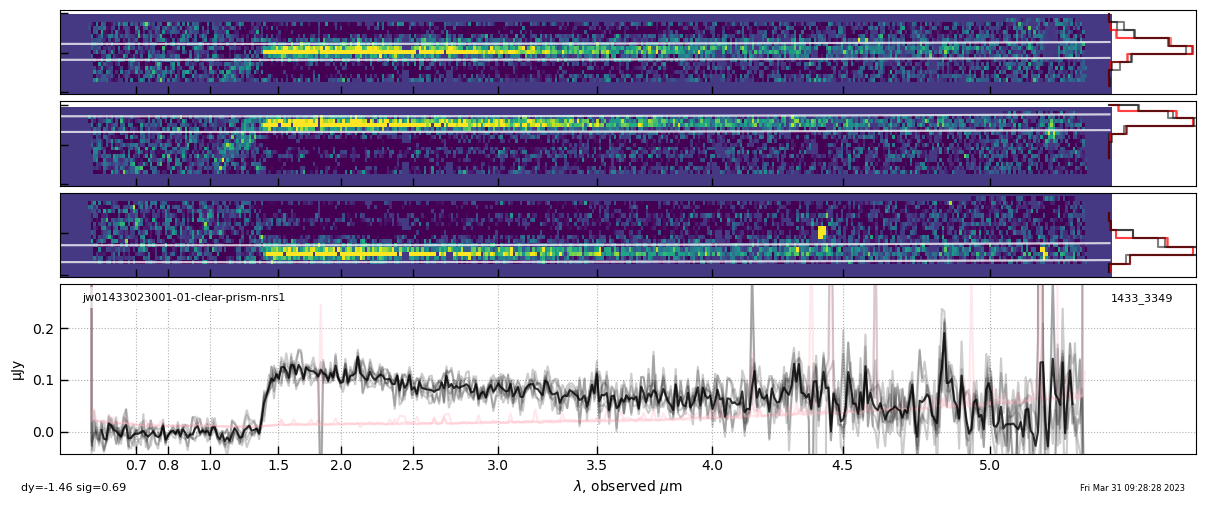

In [31]:
key = f'1433_{target}'

_data = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=-1, 
                              fit_profile_params={'min_delta':20})

slitlet, sep1d, opt1d, fig = _data

slits = pipe.get_background_slits(key, step='bkg', check_background=True)
print(len(slits))

msaexp.drizzle.drizzle_slitlets: 3349 read 3 files
msaexp.drizzle.drizzle_slitlets: id=3349  prism-clear N=3
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  1433_3349
msaexp.drizzle.drizzle_slitlets: output size = (31, 414)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 1433_3349               3349 -0.272 <SlitModel(20, 427) from jw01433023001_04101_00001_nrs1_phot.101.1433_3349.fits> (20, 427)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 1433_3349               3349 -0.277 <SlitModel(20, 427) from jw01433023001_04101_00002_nrs1_phot.101.1433_3349.fits> (20, 427)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 1433_3349               3349 -0.267 <SlitModel(20, 427) from jw01433023001_04101_00003_nrs1_phot.101.1433_3349.fits> (20, 427)


2023-03-31 09:29:44,724 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


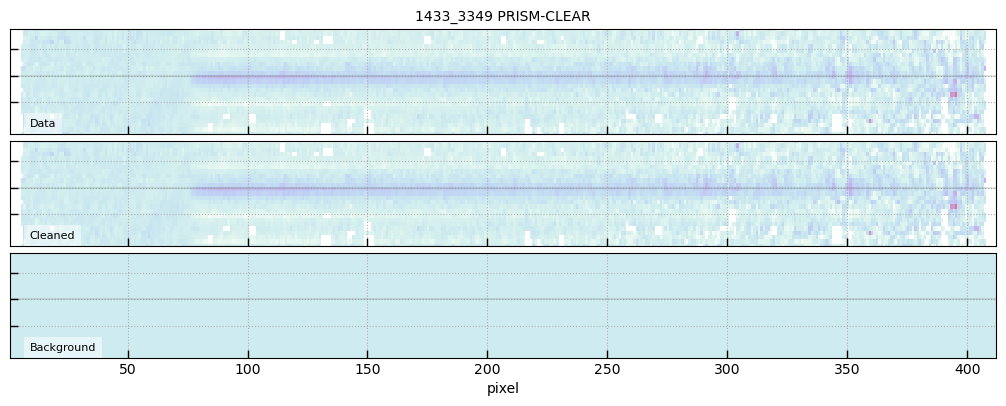

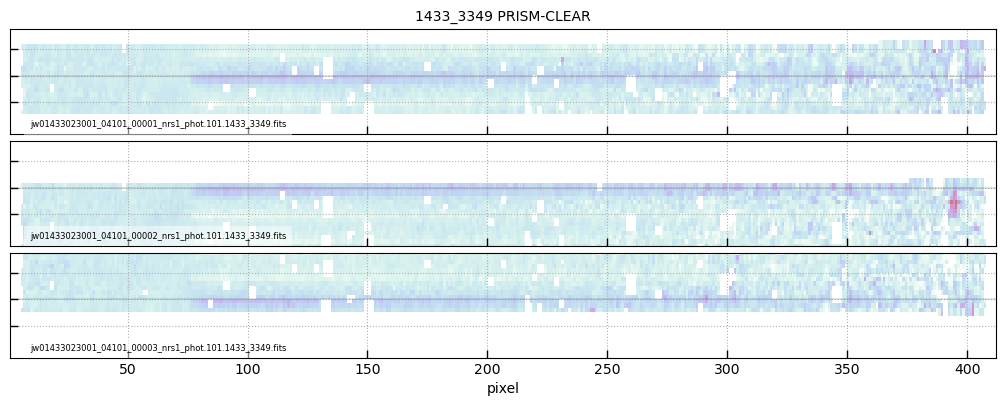

In [33]:
_ = msaexp.drizzle.drizzle_slitlets(target,
                                    output='x'+outroot,
                                    files=slits,
                                    master_bkg=0, # Now don't do background subtraction here
                                    center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                    fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                    force_nypix=31,         # Y size of output array
                                    bkg_offset=6,           # Number of pixels to roll for background subtraction
                                    bkg_parity=[],      # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                    log_step=False,         # Log wavelength steps
                                    outlier_threshold=10,   # Outlier rejection threshold
                                    err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                    show_drizzled=True,     # Figures
                                    show_slits=True,
                                    imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                    sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                    bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                   )

figs, hdu_data, wavedata, all_slits, drz_data = _

msaexp.drizzle.extract_from_hdul: Initial center =    1.33, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =   1.05, sigma =   1.20


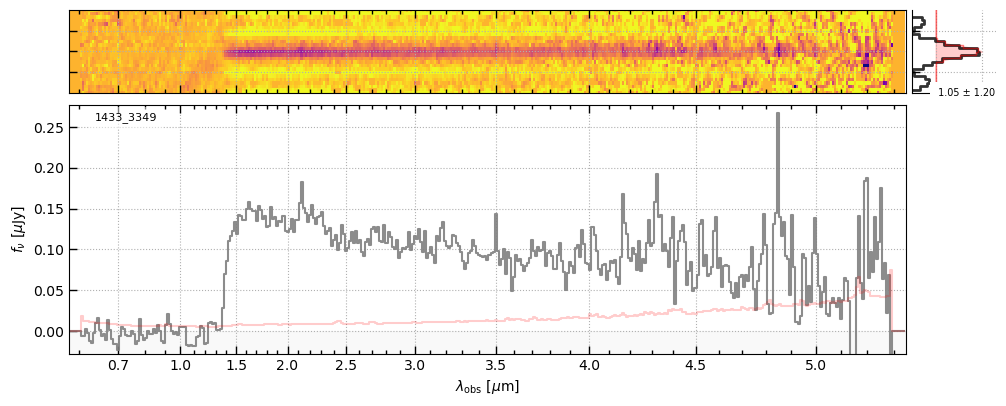

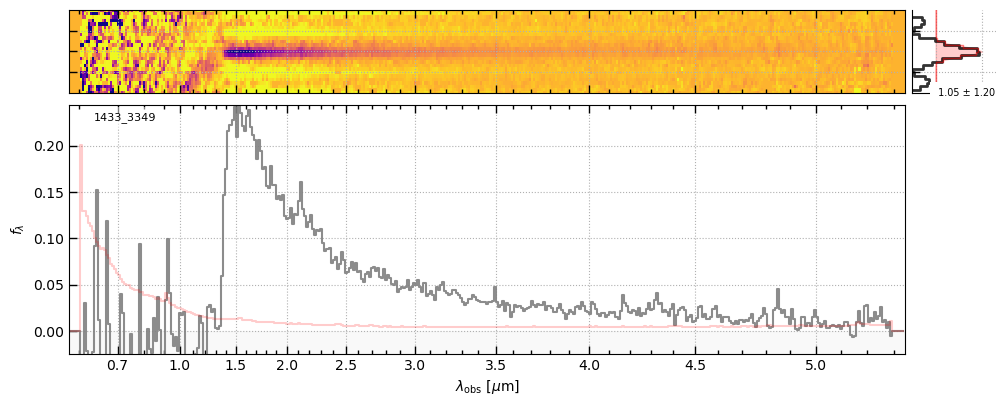

In [34]:
hdul = hdu_data['prism-clear']

outhdu = msaexp.drizzle.extract_from_hdul(hdul,
                                          prf_sigma=0.9, fix_sigma=False,
                                          prf_center=None, fix_center=False,
                                          verbose=True,
                                          )

outhdu.writeto(f'x{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

# Make figures
fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
fig.savefig(f'x{outroot}_{target}.{file_version}.fnu.png')

fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam')
fig.savefig(f'x{outroot}_{target}.{file_version}.flam.png')


In [20]:
# Break when running full notebook
print(break)


SyntaxError: invalid syntax (3373949653.py, line 2)

# Fit all targets

In [21]:
files = glob.glob('jw01433023001*phot*fits')
files.sort()
targets = [f.split('.')[-2].split('_')[-1] for f in files]
targets = np.unique(targets)

so = np.argsort(np.cast[int](targets))
targets = targets[so]
targets

array(['731', '756', '886', '1039', '1045', '1106', '1120', '1152',
       '1167', '1169', '1256', '1281', '1287', '1312', '1319', '1395',
       '1555', '1686', '1715', '1717', '1734', '1742', '1853', '1930',
       '1934', '1944', '2209', '2745', '3035', '3066', '3208', '3251',
       '3261', '3262', '3314', '3329', '3345', '3349', '3501', '3533',
       '3568', '3582', '3593', '3693', '3754', '3777', '3887', '3996',
       '4011', '4031', '4105', '4157', '4188', '4226', '4238', '4269',
       '4274', '4298', '4384', '4428', '4461', '4474', '4503', '4517',
       '4554', '4648', '4681', '4720', '50412', '50415', '50419', '50420',
       '50454', '50456', '50496', '50499', '50507', '50508', '50510',
       '50512', '50513', '50547', '50548', '50551', '50554', '50578',
       '50590', '50592', '50612', '50657', '50671', '50672', '50693',
       '50707', '50713', '50745', '50747', '50749', '50752', '50753',
       '50767', '50768', '50789', '50807', '50811', '50847', '50849',
       '50

In [22]:

def run_everything(target, skip=True):
    """
    Run all steps
    """
    
    if os.path.exists(f'{outroot}_{target}.{file_version}.flam.png') & skip:
        print(f'Skip: {target}')
        return True
    
    slit_files = []
    for file in pipe.files:
        slit_files.extend(glob.glob(f"{file.split('nrs')[0]}*phot*{target}*fits"))

    slit_files.sort()
    if len(slit_files) == 0:
        return False

    DRIZZLE_PARAMS = copy.deepcopy(msaexp.drizzle.DRIZZLE_PARAMS)
    DRIZZLE_PARAMS['kernel'] = 'square'
    DRIZZLE_PARAMS['pixfrac'] = 1.0

    _ = msaexp.drizzle.drizzle_slitlets(target,
                                        output=outroot,
                                        files=slit_files[:],
                                        center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                        fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                        force_nypix=31,         # Y size of output array
                                        bkg_offset=6,           # Number of pixels to roll for background subtraction
                                        bkg_parity=[-1,1],      # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                        log_step=False,         # Log wavelength steps
                                        outlier_threshold=10,   # Outlier rejection threshold
                                        err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                        show_drizzled=True,     # Figures
                                        show_slits=True,
                                        imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                        sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                        bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                       )

    figs, hdu_data, wavedata, all_slits, drz_data = _

    # Optimal extraction
    hdul = hdu_data['prism-clear']

    outhdu = msaexp.drizzle.extract_from_hdul(hdul,
                                              prf_sigma=0.9, fix_sigma=False,
                                              prf_center=None, fix_center=False,
                                              verbose=True,
                                              )

    outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

    # Make figures
    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
    fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam')
    fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')

    # Fit redshift

    msaexp.spectrum.FFTSMOOTH = True

    file = f'{outroot}_{target}.{file_version}.spec.fits'

    zfit_kwargs = dict(z0=[1.0, 11],
                       eazy_templates=templ,
                       vel_width=50,
                       scale_disp=1.0,
                       nspline=11,
                       Rline=2000,
                       use_full_dispersion=False,
                       is_prism=True,
                       sys_err=0.02,
                       ranges=((4600, 6800), (8800, 1.1e4)),
                      )

    plt_kwargs = dict(eazy_templates=None,
                      vel_width=50,
                      scale_disp=1.0,
                      nspline=11,
                      Rline=2000,
                      use_full_dispersion=True,
                      is_prism=True,
                      sys_err=0.02,
                      ranges=((4600, 6800), (8800, 1.1e4)),
                      scale_uncertainty_kwargs={'order':4},
                      plot_unit=u.microJansky,
                      )

    zfit = msaexp.spectrum.fit_redshift(file=file, **zfit_kwargs)

    # Scale uncertainties
    best_z = zfit[1].meta['z']

    if target in ['3349', '3593', '3314']:
        best_z = 10.17145

    msaexp.spectrum.SCALE_UNCERTAINTY = 1.

    _ = msaexp.spectrum.plot_spectrum(file=file,
                                      z=best_z,
                                      **plt_kwargs,
                                      )

    #
    # Refit with just line templates

    best_z = zfit[1].meta['z']

    zfit_kwargs['z0'] = best_z + np.array([-0.1, 0.1])*(1+best_z)
    zfit_kwargs['eazy_templates'] = None

    zfit = msaexp.spectrum.fit_redshift(file=file, zstep=(0.0005, 0.0001), **zfit_kwargs)

    best_z = zfit[1].meta['z']
    
    # Remake figures
    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu', z=best_z)
    fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam', z=best_z)
    fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')
    
    return True


In [23]:
run_everything('3349')

Skip: 3349


True

In [ ]:
for target in targets:
    try:
        run_everything(target)
    except:
        pass
    
    plt.close('all')

Skip: 731
Skip: 756
Skip: 886
Skip: 1039
Skip: 1045
Skip: 1106
Skip: 1120
Skip: 1152
Skip: 1167
Skip: 1169
Skip: 1256
Skip: 1281
Skip: 1287
Skip: 1312
Skip: 1319
Skip: 1395
Skip: 1555
Skip: 1686
Skip: 1715
Skip: 1717
Skip: 1734
Skip: 1742
Skip: 1853
Skip: 1930
msaexp.drizzle.drizzle_slitlets: id=1934  prism-clear N=6


2023-02-23 16:52:25,550 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/msaexp/utils.py:600: RuntimeWarning: All-NaN slice encountered
  refmodel_data -= np.nanmin(refmodel_data)

2023-02-23 16:52:25,612 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/jwst/resample/resample_spec.py:106: RuntimeWarning: All-NaN slice encountered
  refmodel_data -= np.nanmin(refmodel_data)



Skip: 1944
Skip: 2209
Skip: 2745
Skip: 3035
Skip: 3066
Skip: 3208
Skip: 3251
Skip: 3261
Skip: 3262
Skip: 3314
Skip: 3329
Skip: 3345
Skip: 3349
Skip: 3501
Skip: 3533
Skip: 3568
Skip: 3582
Skip: 3593
Skip: 3693
Skip: 3754
Skip: 3777
Skip: 3887
Skip: 3996
Skip: 4011
Skip: 4031
Skip: 4105
Skip: 4157
Skip: 4188
Skip: 4226
Skip: 4238
msaexp.drizzle.drizzle_slitlets: id=4269  prism-clear N=3
msaexp.drizzle.drizzle_slitlets: prism-clear  0 1433_4269               4269 -0.281 jw01433023001_04101_00001_nrs1_phot.075.1433_4269.fits (20, 427)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 1433_4269               4269 -0.294 jw01433023001_04101_00002_nrs1_phot.075.1433_4269.fits (20, 427)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 1433_4269               4269 -0.268 jw01433023001_04101_00003_nrs1_phot.075.1433_4269.fits (20, 427)


2023-02-23 16:52:32,601 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


xxx init  30590 38502 12834
msaexp.drizzle.extract_from_hdul: Initial center =   0.36, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =   1.70, sigma =   1.01


896it [00:01, 479.19it/s]
101it [00:00, 451.92it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# macsj0647_4269.v1.spec.fits
# z = 5.02510
# Thu Feb 23 16:52:35 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# macsj0647_4269.v1.spec.fits
# z = 5.02510
# Thu Feb 23 16:52:35 2023
             line Hb        5.0 ±      8.6
             line Hg        0.6 ±     20.7
             line Hd       36.9 ±     13.7
         line Ha+NII       14.8 ±      6.0
     line NeIII-3968       21.8 ±     14.3
      line OIII-4959       -0.3 ±      8.5
      line OIII-5007        9.9 ±      8.4
      line OIII-4363        5.6 ±     21.2
            line OII       14.1 ±     16.9
      line HeII-4687       -3.7 ±      9.4
     line NeIII-3867       28.7 ±     15.5
            line SII        7.5 ±      6.1
       line OII-7325        0.1 ±      5.8
     line ArIII-7138       10.8 ±      5.9
        line OI-6302      -12.8 ±      7.7
       line HeI-5877       -5.2 ±      5.6
      line OIII-1663      139.8 ±     64.9
      line CIII-1908        2.8 ±     51.

2023-02-23 16:52:36,236 - stpipe - WARNING - Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
2023-02-23 16:52:36,237 - stpipe - WARNING - Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
2023-02-23 16:52:36,239 - stpipe - WARNING - Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping


Set SCALE_UNCERTAINTY:  [ 0.00431097 -0.04581977  0.18147577 -0.3653881   0.33299339]

# line flux err
# flux x 10^-20 erg/s/cm2
# macsj0647_4269.v1.spec.fits
# z = 5.02510
# Thu Feb 23 16:52:36 2023
             line Hb        5.2 ±      8.0
             line Hg        0.3 ±     18.8
             line Hd       36.6 ±     12.3
         line Ha+NII       14.9 ±      5.2
     line NeIII-3968       21.5 ±     12.7
      line OIII-4959       -0.2 ±      7.9
      line OIII-5007       10.0 ±      7.8
      line OIII-4363        5.6 ±     19.4
            line OII       14.2 ±     14.9
      line HeII-4687       -3.7 ±      8.7
     line NeIII-3867       28.5 ±     13.8
            line SII        7.6 ±      5.2
       line OII-7325        0.0 ±      4.8
     line ArIII-7138       10.8 ±      4.9
        line OI-6302      -12.7 ±      6.8
       line HeI-5877       -5.3 ±      5.1
      line OIII-1663      146.5 ±     65.3
      line CIII-1908        5.6 ±     48.8
      line NIII-1750      

402it [00:03, 123.46it/s]
101it [00:00, 105.97it/s]
2023-02-23 16:52:41,536 - stpipe - WARNING - Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
2023-02-23 16:52:41,537 - stpipe - WARNING - Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
2023-02-23 16:52:41,539 - stpipe - WARNING - Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping



# line flux err
# flux x 10^-20 erg/s/cm2
# macsj0647_4269.v1.spec.fits
# z = 5.44988
# Thu Feb 23 16:52:41 2023
             line Hb        2.6 ±      6.9
             line Hg       38.3 ±     12.8
             line Hd       -9.4 ±     11.8
         line Ha+NII       -3.5 ±      4.9
     line NeIII-3968        3.3 ±     12.3
      line OIII-4959       10.7 ±      6.9
      line OIII-5007       -5.1 ±      6.5
      line OIII-4363      -23.9 ±     12.7
            line OII       33.4 ±     12.8
      line HeII-4687       10.2 ±      7.7
     line NeIII-3867       21.6 ±     12.0
            line SII        7.5 ±      5.5
       line OII-7325        5.6 ±      5.5
     line ArIII-7138       19.1 ±      5.0
        line OI-6302        1.7 ±      6.3
       line HeI-5877      -15.7 ±      5.0
      line OIII-1663      -78.9 ±     57.1
      line CIII-1908      -33.6 ±     45.5
      line NIII-1750       34.6 ±     50.7
            line Lya     -130.6 ±    101.6
           line MgII      